# Causal Modeling DML - Modeling Selection & Validation

Author: Lujun LI

Based on the data we have, we primarily use DML as our CATE estimation framework. Our goal is to find the best model for different scenarios.

The basic framework we use is from EconML, which includes:
- Linear DML
- Sparse Linear DML
- NoParamDML
- Causal Forest DML

The model functions we use are mainly chosen from:
- Linear Regression
- Lasso
- Ridge Regression
- Random Forest Regressor
- XGBoost Regressor
- LGBM Regressor

For validation, we mainly use R score, MAPE, and the score function to evaluate model performance. We divide the interventional data into 60% training data and 40% validation data.

Grid Search will be used for hyperparameter tuning to find the best hyperparameters for each model. The `model_y`, `model_t`, and `model_final` may use different fitting models.

The estimation of marginal CATE will be obtained at different temperatures, and then the shape values will be used for further explanation.


In [1]:
from econml.dml import DML, LinearDML, SparseLinearDML, CausalForestDML
import numpy as np
from itertools import product
from sklearn.linear_model import (Lasso, LassoCV, LogisticRegression,
                                  LogisticRegressionCV,LinearRegression,
                                  MultiTaskElasticNet,MultiTaskElasticNetCV)
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
%matplotlib inline

networkx backend defined more than once: nx-loopback


Let's import a test set and try to run normally every model we want to check

In [2]:
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
import numpy as np

current_time = datetime.datetime.now()
current_time_str = current_time.strftime("%Y%m%d%H%M%S")
model_weight_sizes = {
    "Llama-2-13b-chat-hf": 13,
    "Mistral-7B-Instruct-v0.2": 7,
    "Llama-2-70b-chat-hf": 70,
    "Meta-Llama-3-8B-Instruct": 8,
    "Llama-2-7b-chat-hf": 7,
    "Mixtral-8x7B-Instruct-v0.1": 56,
}

folder_path = "Paper Experiment Results/New_filtered/ICL"
output_photo_name = f"IF_{current_time_str}.svg"
output_photo_path = os.path.join(folder_path, output_photo_name)
all_dfs = []
for filename in os.listdir(folder_path):
    if filename.endswith(".csv") and "evaluated" in filename:
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        model_name = filename.split("_")[2]
        df["model_name"] = model_name
        df["weight_size"] = model_weight_sizes.get(model_name, None)
        all_dfs.append(df)

df = pd.concat(all_dfs, ignore_index=True)


scaler = MinMaxScaler()
df["qa_f1_score_normalized"] = scaler.fit_transform(df[["qa_f1_score"]])
df["classification_score_normalized"] = scaler.fit_transform(
    df[["classification_score"]]
)
df["composite_score"] = np.where(
    df["qa_f1_score"].notnull(), df["qa_f1_score"], df["classification_score"]
)

df["Temperature"] = df["Temperature"].astype(float).round(1)

one_hot_model = pd.get_dummies(df["model_name"], dtype=int)
model_columns = one_hot_model.columns.tolist()
df = pd.concat([df, one_hot_model], axis=1)

model_map = {
    "Llama-2-7b-chat-hf": 0,
    "Llama-2-13b-chat-hf": 1,
    "Llama-2-70b-chat-hf": 2,
    "Meta-Llama-3-8B-Instruct": 3,
    "Meta-Llama-3-70B-Instruct": 4,
    "Mistral-7B-Instruct-v0.2": 5,
    "Mixtral-8x7B-Instruct-v0.1": 6,
}

marker_map = {
    "Llama-2-7b-chat-hf": ".",
    "Llama-2-13b-chat-hf": "*",
    "Llama-2-70b-chat-hf": "o",
    "Meta-Llama-3-8B-Instruct": "+",
    "Meta-Llama-3-70B-Instruct": "^",
    "Mistral-7B-Instruct-v0.2": "<",
    "Mixtral-8x7B-Instruct-v0.1": ">",
}

color_map = {
    "Llama-2-7b-chat-hf": "C0",
    "Llama-2-13b-chat-hf": "C1",
    "Llama-2-70b-chat-hf": "C2",
    "Meta-Llama-3-8B-Instruct": "C3",
    "Meta-Llama-3-70B-Instruct": "C4",
    "Mistral-7B-Instruct-v0.2": "C5",
    "Mixtral-8x7B-Instruct-v0.1": "C6",
}

folder_path = "Paper Experiment Results/New_filtered/ICL"
df["pure_response"] = df["pure_response"].astype(str)
df["pure_response_length"] = df["pure_response"].apply(len)
df["time_per_char"] = df["elapsed_time"] / df["pure_response_length"]
df["Temperature"] = df["Temperature"].round(1)
df["model_encoded"] = df["model_name"].map(model_map)

node_labels = [
    "Temperature",
    "model_encoded",
    "composite_score",
] + model_columns

causal_dataset_df = df[node_labels]

grouped = causal_dataset_df.groupby(["model_encoded", "Temperature"])
train_set = pd.DataFrame()
validation_set = pd.DataFrame()
for name, group in grouped:
    split_index = int(len(group) * 0.6)
    train = group.iloc[:split_index]
    validation = group.iloc[split_index:]
    train_set = pd.concat([train_set, train])
    validation_set = pd.concat([validation_set, validation])

# Temperature Scaling
start = 0.1
stop = 2.1
step = 0.3
control_values = np.arange(start, stop, step)

At this time we got trainset set and validation set and let's check if that's correct.

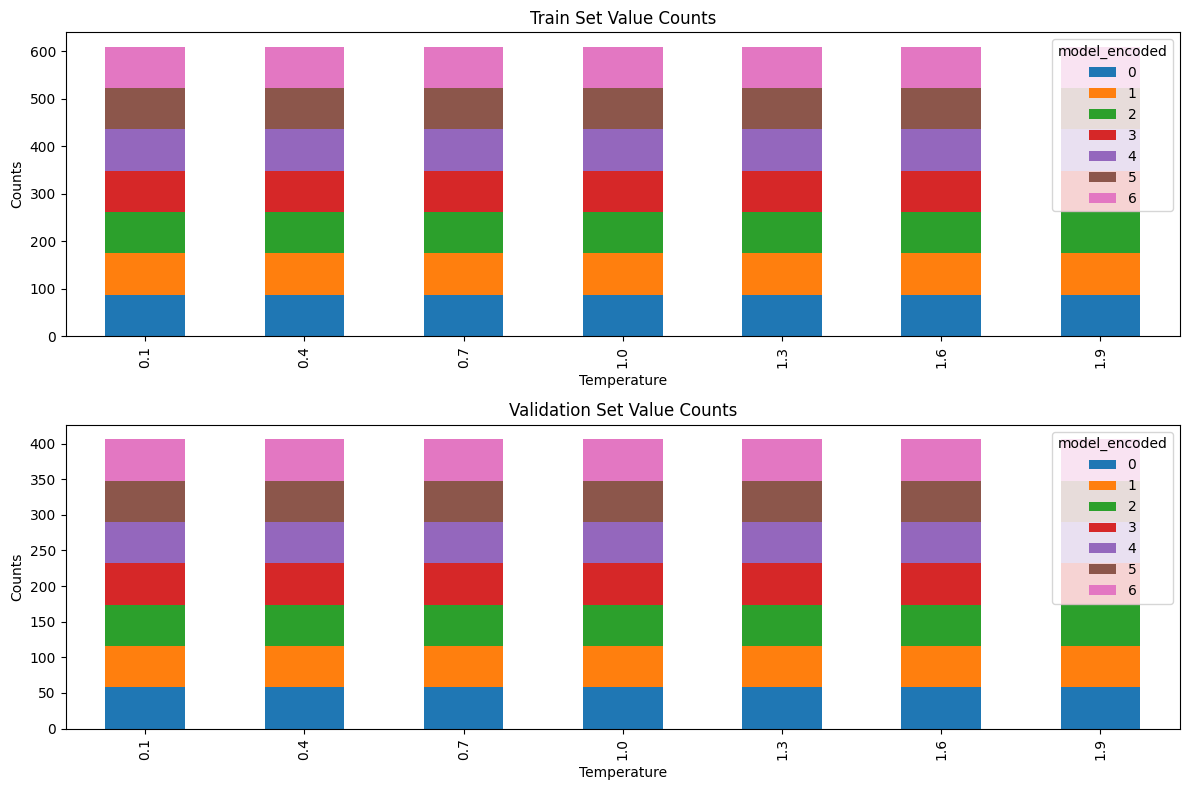

In [6]:
train_counts = (
    train_set[["Temperature", "model_encoded"]].value_counts().unstack(fill_value=0)
)
validation_counts = (
    validation_set[["Temperature", "model_encoded"]]
    .value_counts()
    .unstack(fill_value=0)
)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

train_counts.plot(kind="bar", stacked=True, ax=axes[0], title="Train Set Value Counts")
validation_counts.plot(
    kind="bar", stacked=True, ax=axes[1], title="Validation Set Value Counts"
)
axes[0].set_xlabel("Temperature")
axes[0].set_ylabel("Counts")
axes[1].set_xlabel("Temperature")
axes[1].set_ylabel("Counts")

plt.tight_layout()
plt.show()

cols = model_columns
T_train = train_set["Temperature"].values
X_train = train_set[cols].values
Y_train = train_set["composite_score"].values
T_val = validation_set["Temperature"].values
X_val = validation_set[cols].values
Y_val = validation_set["composite_score"].values
T = causal_dataset_df["Temperature"].values
X = causal_dataset_df[cols].values
Y = causal_dataset_df["composite_score"].values

Let's start with the first model

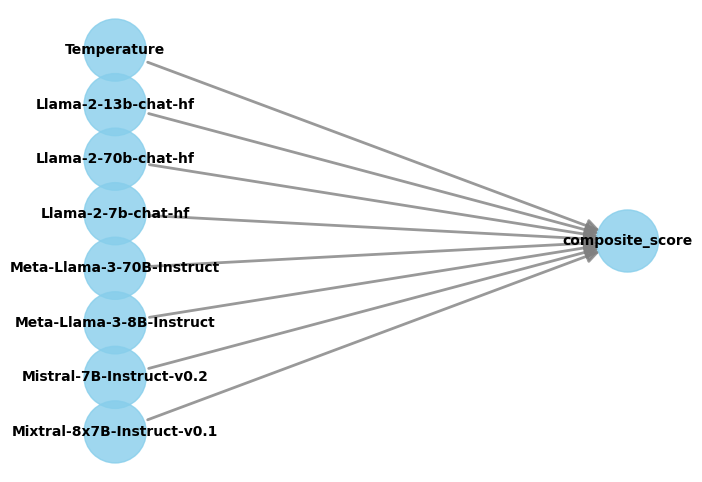

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                           
──────────────(E[composite_score])
d[Temperature]                    
Estimand assumption 1, Unconfoundedness: If U→{Temperature} and U→composite_score then P(composite_score|Temperature,,U) = P(composite_score|Temperature,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



/home/lujun/.local/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
/home/lujun/.local/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
/home/lujun/.local/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
/home/lujun/.local/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
/home/lujun/.local/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.ba

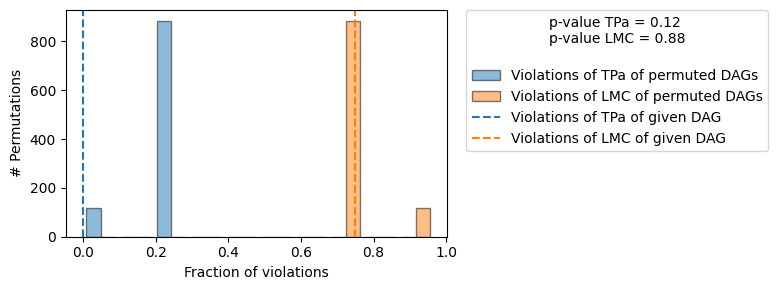

In [7]:
from dowhy import CausalModel
from dowhy.gcm.falsify import falsify_graph

model = CausalModel(
    data=train_set,
    treatment=["Temperature"],
    outcome=["composite_score"],
    effect_modifiers=cols,
)
model.view_model()

identified_estimand = model.identify_effect()
print(identified_estimand)

result = falsify_graph(
    causal_graph=model._graph._graph,
    data=causal_dataset_df,
    plot_histogram=True,
    n_permutations=1000,
    suggestions=True,
)

dict_summary = result.__dict__["summary"]

keys = list(dict_summary.keys())
if len(keys) >= 2:
    TPA = keys[0]
    LMC = keys[1]

# Graph Refutation 1
p_value_TPA = [
    value for key, value in dict_summary[TPA].items() if "P_VALUE" in key.name
][0]
# Graph Refutation 2
p_value_LMC = [
    value for key, value in dict_summary[LMC].items() if "P_VALUE" in key.name
][0]

In [10]:
# p_value_TPA
p_value_LMC

In [11]:
from sklearn.linear_model import LassoCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from econml.sklearn_extensions.linear_model import WeightedLassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from econml.sklearn_extensions.model_selection import GridSearchCVList
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from econml.sklearn_extensions.linear_model import WeightedLasso
from sklearn.base import clone
from econml.dml import DML, LinearDML, SparseLinearDML, NonParamDML

model_y_list = GridSearchCVList(
    [
        Lasso(max_iter=10000),
        RandomForestRegressor(random_state=123),
        GradientBoostingRegressor(random_state=123),
    ],
    param_grid_list=[
        {"alpha": [0.001, 0.01, 0.1, 1, 10]},
        {"max_depth": [3, 5], "min_samples_leaf": [10, 50]},
        {
            "n_estimators": [50, 100],
            "max_depth": [3, 5],
            "min_samples_leaf": [10, 30, 50],
        },
    ],
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,  # use parallel
)

model_t_list = GridSearchCVList(
    [
        Lasso(max_iter=10000),
        RandomForestRegressor(n_estimators=100, random_state=123),
        GradientBoostingRegressor(random_state=123),
    ],
    param_grid_list=[
        {"alpha": [0.001, 0.01, 0.1, 1, 10]},
        {"max_depth": [3, 5], "min_samples_leaf": [10, 50]},
        {
            "n_estimators": [50, 100],
            "max_depth": [3, 5],
            "min_samples_leaf": [10, 30, 50],
        },
    ],
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
)


model_final = GridSearchCVList(
    [
        WeightedLasso(max_iter=10000),
        RandomForestRegressor(n_estimators=100, random_state=123),
    ],
    param_grid_list=[
        {"alpha": [0.001, 0.01, 0.1, 1, 10]},
        {"max_depth": [3, 5], "min_samples_leaf": [10, 50]},
        {},
    ],
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
)

featurizer = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)
model_y_best = model_y_list.fit(X_train, Y_train.ravel()).best_estimator_
model_t_best = model_t_list.fit(X_train, Y_train.ravel()).best_estimator_

dml_estimate_linear = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.econml.dml.LinearDML",
    method_params={
        "init_params": {
            "model_y": "auto",
            "model_t": "auto",
            "treatment_featurizer": featurizer,
            "cv": 5,
        }
    },
    fit_estimator=True,
)

dml_estimate_CausalForest = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.econml.dml.CausalForestDML",
    method_params={
        "init_params": {
            "model_y": "auto",
            "model_t": "auto",
            "treatment_featurizer": featurizer,
            "cv": 5,
            "n_estimators": 2000,
            "random_state": 123,
        }
    },
    fit_estimator=True,
)

dml_estimate_NonParamDML = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.econml.dml.NonParamDML",
    method_params={
        "init_params": {
            "model_y": "auto",
            "model_t": "auto",
            # "treatment_featurizer": featurizer,
            "model_final": model_final,
            "cv": 5,
        }
    },
    fit_estimator=True,
)

Objective did not converge. You might want to increase the number of iterations. Duality gap: 908.5648923992485, tolerance: 2.5568643076957476
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1005.1763903427964, tolerance: 2.5568643076957476
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1005.7853444007196, tolerance: 2.5568643076957476
Objective did not converge. You might want to increase the number of iterations. Duality gap: 881.8427691986544, tolerance: 2.5568643076957476
Objective did not converge. You might want to increase the number of iterations. Duality gap: 720.2430860497989, tolerance: 2.5568643076957476
Objective did not converge. You might want to increase the number of iterations. Duality gap: 936.9569503644816, tolerance: 2.5568643076957476
Objective did not converge. You might want to increase the number of iterations. Duality gap: 911.3444655580315, tolerance: 2.55686430769574

In [7]:
# est.fit(Y=Y_train, T=T_train.reshape(-1, 1), X=X_train)

# est.models_y[0][1].get_params()
# est.models_y[0][1].feature_importances_

In [13]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

# control_temp_values = np.arange(0.1, 2.1, 0.3)
# control_temp = 0.1
# target_temp = control_temp + 0.3


def calculate_true_effect(validation_set, control_temp, target_temp):
    control_data = validation_set[validation_set["Temperature"] == control_temp][
        "composite_score"
    ].reset_index(drop=True)
    target_data = validation_set[validation_set["Temperature"] == target_temp][
        "composite_score"
    ].reset_index(drop=True)

    min_length = min(len(control_data), len(target_data))
    control_data = control_data[:min_length]
    target_data = target_data[:min_length]

    if not control_data.empty and not target_data.empty:
        true_effect = target_data - control_data
        ate = true_effect.mean()  # Calculate the average treatment effect (ATE)
    else:
        ate = None

    return ate, min_length


def calculate_ates(validation_set, dml_estimate, calculate_true_effect, is_plot=False):
    """
    Calculate true and predicted Average Treatment Effects (ATEs) for temperature ranges.

    Args:
    validation_set (DataFrame): The validation dataset containing Temperature column.
    dml_estimate (object): The Double Machine Learning estimator object.
    calculate_true_effect (function): Function to calculate the true effect.

    Returns:
    tuple: A tuple containing two lists: true_ates and predict_ates.
    """
    true_ates = []
    predict_ates = []
    temperatures = sorted(validation_set["Temperature"].unique())
    estimator_econml = dml_estimate.estimator.estimator

    for i in range(len(temperatures) - 1):
        control_temp = temperatures[i]
        target_temp = temperatures[i + 1]
        true_ate, min_length = calculate_true_effect(
            validation_set, control_temp, target_temp
        )
        true_ates.append(true_ate)
        predict_ate = estimator_econml.ate(
            X=validation_set[validation_set["Temperature"] == control_temp][cols],
            T0=control_temp,
            T1=target_temp,
        )
        predict_ates.append(predict_ate)

    if is_plot:
        # To see the results of the predictied ATE and true ATE in the validation sets.
        plt.figure(figsize=(10, 6))
        plt.plot(temperatures[:-1], true_ates, label="True ATE", marker="o")
        plt.plot(temperatures[:-1], predict_ates, label="Predicted ATE", marker="x")
        plt.xlabel("Temperature")
        plt.ylabel("ATE")
        plt.title("True ATE vs Predicted ATE by Temperature")
        plt.legend()
        plt.grid(True)
        plt.show()
    return true_ates, predict_ates


true_ates_linear, predict_ates_linear = calculate_ates(
    validation_set, dml_estimate_linear, calculate_true_effect, is_plot=False
)

true_ates_CausalForest, predict_ates_CausalForest = calculate_ates(
    validation_set, dml_estimate_CausalForest, calculate_true_effect, is_plot=False
)
true_ates_NonParamDML, predict_ates_NonParamDML = calculate_ates(
    validation_set, dml_estimate_NonParamDML, calculate_true_effect, is_plot=False
)

# Estimation results on the validation sets.
mse_results = {}

mse_results["linear"] = mean_squared_error(true_ates_linear, predict_ates_linear)
mse_results["CausalForest"] = mean_squared_error(
    true_ates_CausalForest, predict_ates_CausalForest
)
mse_results["NonParamDML"] = mean_squared_error(
    true_ates_NonParamDML, predict_ates_NonParamDML
)

In [14]:
# Calculate MSE for the best model
true_ates_linear_val, predict_ates_linear_val = calculate_ates(
    validation_set, dml_estimate_linear, calculate_true_effect, is_plot=False
)

true_ates_CausalForest_val, predict_ates_CausalForest_val = calculate_ates(
    validation_set, dml_estimate_CausalForest, calculate_true_effect, is_plot=False
)

true_ates_NonParamDML_val, predict_ates_NonParamDML_val = calculate_ates(
    validation_set, dml_estimate_NonParamDML, calculate_true_effect, is_plot=False
)

true_ates_linear_train, predict_ates_linear_train = calculate_ates(
    train_set, dml_estimate_linear, calculate_true_effect, is_plot=False
)

true_ates_CausalForest_train, predict_ates_CausalForest_train = calculate_ates(
    train_set, dml_estimate_CausalForest, calculate_true_effect, is_plot=False
)

true_ates_NonParamDML_train, predict_ates_NonParamDML_train = calculate_ates(
    train_set, dml_estimate_NonParamDML, calculate_true_effect, is_plot=False
)

mse_results_val = {}

mse_results_val["linear"] = mean_squared_error(
    true_ates_linear_val, predict_ates_linear_val
)
mse_results_val["CausalForest"] = mean_squared_error(
    true_ates_CausalForest_val, predict_ates_CausalForest_val
)
mse_results_val["NonParamDML"] = mean_squared_error(
    true_ates_NonParamDML_val, predict_ates_NonParamDML_val
)

mse_results_train = {}

mse_results_train["linear"] = mean_squared_error(
    true_ates_linear_train, predict_ates_linear_train
)
mse_results_train["CausalForest"] = mean_squared_error(
    true_ates_CausalForest_train, predict_ates_CausalForest_train
)
mse_results_train["NonParamDML"] = mean_squared_error(
    true_ates_NonParamDML_train, predict_ates_NonParamDML_train
)
print(mse_results_train)
print(mse_results_val)
# Not overfitting

{'linear': 0.00014942443450450136, 'CausalForest': 0.00014915813494407567, 'NonParamDML': 0.00018627917193875604}
{'linear': 4.849199416330733e-05, 'CausalForest': 5.4159232154139866e-05, 'NonParamDML': 6.026616020865998e-05}


Get parameters of each model

In [15]:
# use the best model for the final estimation
# calculate_ates(
#     causal_dataset_df[causal_dataset_df["model_encoded"] == 1],
#     dml_estimate_CausalForest,
#     calculate_true_effect,
#     is_plot=False,
# )

model_encodes = sorted(causal_dataset_df["model_encoded"].unique())  # Get unique values

ates_models = {}
model_map = {
    "Llama-2-7b-chat-hf": 0,
    "Llama-2-13b-chat-hf": 1,
    "Llama-2-70b-chat-hf": 2,
    "Meta-Llama-3-8B-Instruct": 3,
    "Meta-Llama-3-70B-Instruct": 4,
    "Mistral-7B-Instruct-v0.2": 5,
    "Mixtral-8x7B-Instruct-v0.1": 6,
}


def find_model_name(model_map, model_encode):
    for key, value in model_map.items():
        if value == model_encode:
            return key
    return None  # Return None if model_name is not found in model_map


for model_encode in model_encodes:
    _, predict_ates = calculate_ates(
        causal_dataset_df[causal_dataset_df["model_encoded"] == model_encode],
        dml_estimate_CausalForest,
        calculate_true_effect,
        is_plot=False,
    )
    model_name = find_model_name(model_map, model_encode)
    ates_models[model_name] = predict_ates

_, predict_avg_ates = calculate_ates(
    causal_dataset_df,
    dml_estimate_CausalForest,
    calculate_true_effect,
    is_plot=False,
)

[0.0001882204214393953, 0.00031715769848508074, -0.0012832282175500032, -0.004612937326664651, -0.009671969628859441, -0.01646032512413279]
[0.028044640235734605, 0.002043307114059742, -0.013184513944675291, -0.017638822940477028, -0.011319619873328635, 0.0057730952567612015]
[-0.012987663450530925, -0.014786421867033037, -0.017723113285363194, -0.021797737705515796, -0.027010295127492617, -0.03336078555129198]
[0.03120326689766389, -0.00793362594414937, -0.03095580256633057, -0.03786326296890183, -0.028656007151859956, -0.003334035115192424]
[-0.007511191204781917, -0.004154703293935018, -0.002775121609446589, -0.003372446151316162, -0.0059466769195437065, -0.010497813914130483]
[-0.0030150137163845944, -0.007380224616961425, -0.009868500416104266, -0.010479841113814926, -0.00921424671009581, -0.006071717204939875]
[0.005831846425705955, -0.002034130112820349, -0.005550837272403013, -0.004718275053041343, 0.0004635565452629359, 0.009994657522510553]
[0.00596487222983373, -0.0048469487

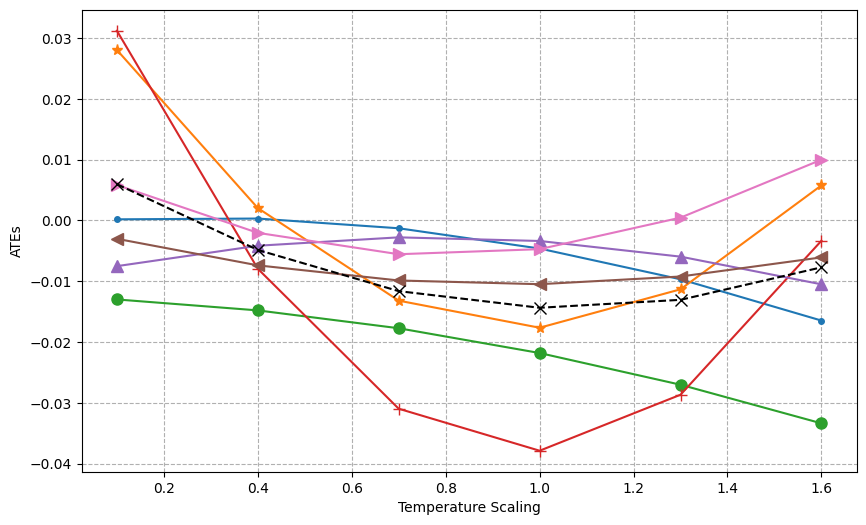

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Plotting the results
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
temperatures = sorted(causal_dataset_df["Temperature"].unique())
for model_name, predict_ates in ates_models.items():
    print(predict_ates)
    plt.plot(
        temperatures[:-1],
        predict_ates,
        label=model_name,
        marker=marker_map[model_name],
        color=color_map[model_name],
        markersize=8,
    )

plt.plot(
    temperatures[:-1],
    predict_avg_ates,
    linestyle="--",
    marker="x",
    markersize=8,
    color="black",
    label="Average Score Among All Models",
)
print(predict_avg_ates)
plt.autoscale()
plt.xlabel("Temperature Scaling")  # Adjust x-axis label as needed
plt.ylabel("ATEs")  # Adjust y-axis label as needed
plt.grid(
    linestyle="--",
)
# plt.title("Average Treatment Effect over Time by Model")  # Adjust title as needed
# plt.legend()  # Show legend with model labels
plt.savefig("ICL.svg", format="svg", bbox_inches="tight")
plt.grid(True)  # Show grid
plt.show()

In [18]:
import shap
import matplotlib.pyplot as plt

est = dml_estimate_CausalForest.estimator.estimator
shap_values = est.shap_values(
    X_val,
    feature_names=cols,
)

100%|===================| 8520/8526 [01:53<00:00]        

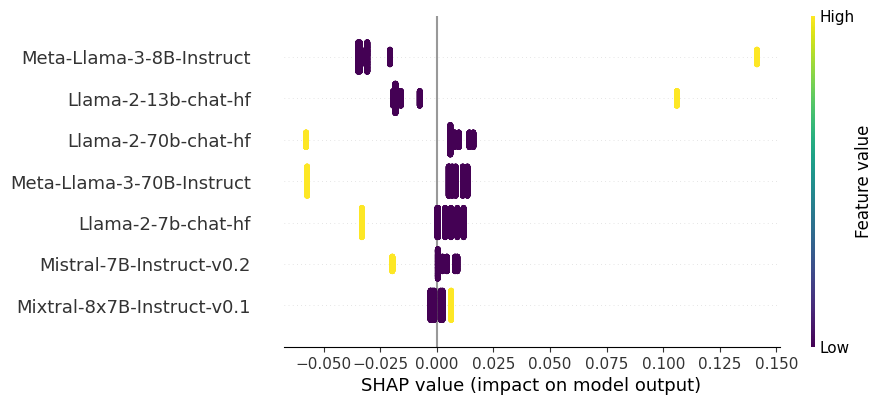

In [19]:
import matplotlib.pyplot as pl
import shap

pl.figure(figsize=(30, 10))
shap.plots.beeswarm(
    shap_values["composite_score"]["Temperature"],
    color=pl.get_cmap("viridis"),
    order=shap_values["composite_score"]["Temperature"].abs.max(0),
    show=False,
)
pl.savefig("beeswarm_plot.pdf", format="pdf", dpi=700)

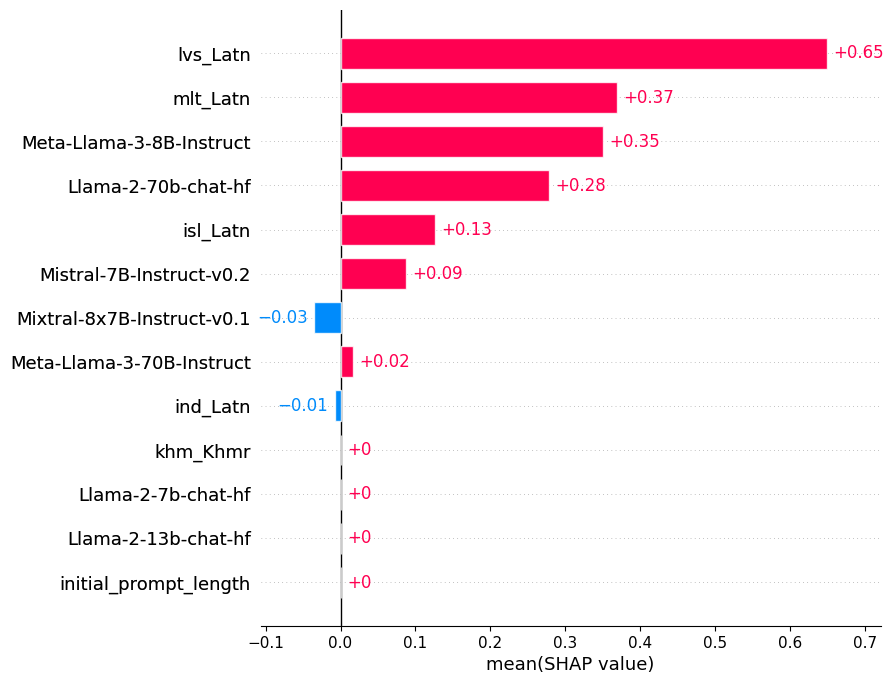

In [44]:
# shap.plots.beeswarm(shap_values["spbleu"]["Temperature"], color="shap_red")

shap.plots.bar(
    shap_values["spbleu"]["Temperature"].mean(0),
    max_display=100,
)

MAPE is not feasible

In [67]:
# from sklearn.metrics import mean_absolute_percentage_error

# control_temp = 0.1
# target_temp = 0.4
# estimator_econml = dml_estimate3.estimator.estimator
# predict_effect = estimator_econml.effect(
#     X=validation_set[validation_set["Temperature"] == control_temp][cols],
#     T0=control_temp,
#     T1=target_temp,
# )


# def calculate_true_effect(validation_set, control_temp, target_temp):
#     temp_01_data = validation_set[validation_set["Temperature"] == control_temp][
#         "spbleu"
#     ].reset_index(drop=True)
#     temp_04_data = validation_set[validation_set["Temperature"] == target_temp][
#         "spbleu"
#     ].reset_index(drop=True)

#     min_length = min(len(temp_01_data), len(temp_04_data))
#     temp_01_data = temp_01_data[:min_length]
#     temp_04_data = temp_04_data[:min_length]

#     if not temp_01_data.empty and not temp_04_data.empty:
#         true_effect = temp_01_data - temp_04_data
#     else:
#         true_effect = None

#     return true_effect.values, min_length


# true_effect, min_length = calculate_true_effect(
#     validation_set, control_temp, target_temp
# )
# mape = mean_absolute_percentage_error(true_effect, predict_effect)
# mape

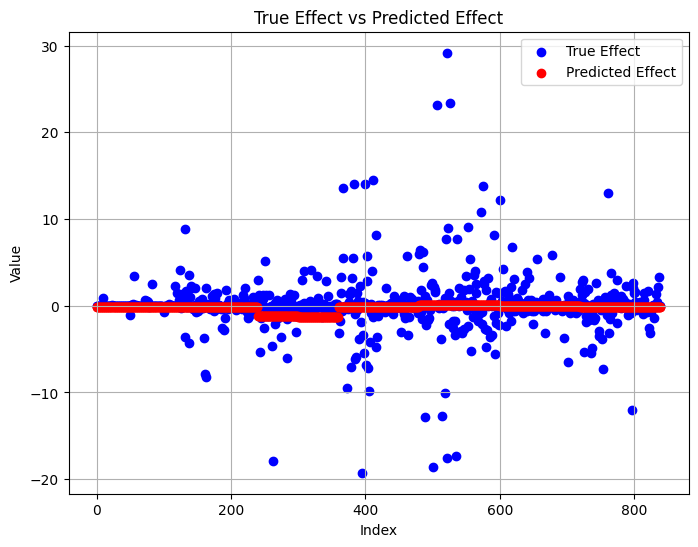

In [70]:
# Plotting true_effect and predict_effect
plt.figure(figsize=(8, 6))
plt.scatter(range(len(true_effect)), true_effect, color="blue", label="True Effect")
plt.scatter(
    range(len(predict_effect)), predict_effect, color="red", label="Predicted Effect"
)
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("True Effect vs Predicted Effect")
plt.legend()
plt.grid(True)
plt.show()

In [71]:
max(true_effect)

In [ ]:
from sklearn.linear_model import LassoCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from econml.sklearn_extensions.linear_model import WeightedLassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from econml.sklearn_extensions.model_selection import GridSearchCVList
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from econml.sklearn_extensions.linear_model import WeightedLasso
from sklearn.base import clone
from econml.dml import DML, LinearDML, SparseLinearDML, NonParamDML

model_y_list = GridSearchCVList(
    [
        Lasso(max_iter=10000),
        RandomForestRegressor(random_state=123),
        GradientBoostingRegressor(random_state=123),
    ],
    param_grid_list=[
        {"alpha": [0.001, 0.01, 0.1, 1, 10]},
        {"max_depth": [3, 5], "min_samples_leaf": [10, 50]},
        {
            "n_estimators": [50, 100],
            "max_depth": [3, 5],
            "min_samples_leaf": [10, 30, 50],
        },
    ],
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,  # use parallel
)

model_t_list = GridSearchCVList(
    [
        Lasso(max_iter=10000),
        RandomForestRegressor(n_estimators=100, random_state=123),
        GradientBoostingRegressor(random_state=123),
    ],
    param_grid_list=[
        {"alpha": [0.001, 0.01, 0.1, 1, 10]},
        {"max_depth": [3, 5], "min_samples_leaf": [10, 50]},
        {
            "n_estimators": [50, 100],
            "max_depth": [3, 5],
            "min_samples_leaf": [10, 30, 50],
        },
    ],
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
)

model_final = GridSearchCVList(
    [
        WeightedLasso(max_iter=10000),
        RandomForestRegressor(n_estimators=100, random_state=123),
    ],
    param_grid_list=[
        {"alpha": [0.001, 0.01, 0.1, 1, 10]},
        {"max_depth": [3, 5], "min_samples_leaf": [10, 50]},
    ],
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
)

featurizer = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)
model_y_best = model_y_list.fit(X_train, Y_train.ravel()).best_estimator_
model_t_best = model_t_list.fit(X_train, Y_train.ravel()).best_estimator_

dml_estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.econml.dml.LinearDML",
    method_params={
        "init_params": {
            "model_y": model_y_best,
            "model_t": model_t_best,
            # "treatment_featurizer": featurizer,
            "cv": 3,
        }
    },
    fit_estimator=True,
)

dml_estimate2 = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.econml.dml.CausalForestDML",
    method_params={
        "init_params": {
            "model_y": model_y_best,
            "model_t": model_t_best,
            # "treatment_featurizer": featurizer,
            "cv": 3,
            "n_estimators": 2000,
            "random_state": 123,
        }
    },
    fit_estimator=True,
)

dml_estimate3 = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.econml.dml.NonParamDML",
    method_params={
        "init_params": {
            "model_y": model_y_best,
            "model_t": model_t_best,
            # "treatment_featurizer": featurizer,
            "model_final": model_final,
            "cv": 3,
        }
    },
    fit_estimator=True,
)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Co-variance matrix is underdetermined. Inference will be invalid!
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A c

Make sure that there is no overfitting to validate DML

In [109]:
# check overfitting
from sklearn.metrics import accuracy_score, mean_squared_error

y_train_pred = model_y_best.predict(X_train)
t_train_pred = model_t_best.predict(X_train)

y_val_pred = model_y_best.predict(X_val)
t_val_pred = model_t_best.predict(X_val)

y_train_mse = mean_squared_error(Y_train, y_train_pred)
y_val_mse = mean_squared_error(Y_val, y_val_pred)
t_train_mse = mean_squared_error(T_train, t_train_pred)
t_val_mse = mean_squared_error(T_val, t_val_pred)

print(f"Model Y - Training MSE: {y_train_mse}")
print(f"Model Y - Validation MSE: {y_val_mse}")
print(f"Model T - Training MSE: {t_train_mse}")
print(f"Model T - Validation MSE: {t_val_mse}")

# estimator_econml = dml_estimate3.estimator.estimator
# result = estimator_econml.effect(
#     X=validation_set[validation_set["Temperature"] == 0.4][cols], T0=0.1, T1=0.4
# )
# true_effect = (
#     validation_set[validation_set["Temperature"] == 0.1]["spbleu"]
#     - validation_set[validation_set["Temperature"] == 0.4]["spbleu"]
# ).values

# plt.figure(figsize=(12, 8))
# sns.histplot(true_effect, kde=True, bins=10, color="blue", label="True Effect")
# sns.histplot(result, kde=True, bins=10, color="red", label="Estimate Effect")
# plt.title("Distribution of True Effect and Estimate Effect")
# plt.xlabel("Effect")
# plt.ylabel("Frequency")
# plt.legend()
# plt.show()

Model Y - Training MSE: 66.11000320860333
Model Y - Validation MSE: 128.3450612078267
Model T - Training MSE: 223.29892231106444
Model T - Validation MSE: 181.45872917417483


In [47]:
true_effect

0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
835    2.121010
836    0.125461
837    3.353148
838    0.000000
839    0.000000
Name: spbleu, Length: 840, dtype: float64

In [25]:
def regressor_stage():
    return GridSearchCVList(
        [
            Lasso(),
            RandomForestRegressor(n_estimators=100, random_state=123),
            GradientBoostingRegressor(random_state=123),
        ],
        param_grid_list=[
            {"alpha": [0.001, 0.01, 0.1, 1, 10]},
            {"max_depth": [3, None], "min_samples_leaf": [10, 50]},
            {"n_estimators": [50, 100], "max_depth": [3], "min_samples_leaf": [10, 30]},
        ],
        cv=5,
        scoring="neg_mean_squared_error",
    )


model_final = GridSearchCVList(
    [WeightedLasso(), RandomForestRegressor(n_estimators=100, random_state=123)],
    param_grid_list=[
        {"alpha": [0.001, 0.01, 0.1, 1, 10]},
        {"max_depth": [3, 5], "min_samples_leaf": [10, 50]},
    ],
    cv=5,
    scoring="neg_mean_squared_error",
)


# Best fit the model y and model t and copy the best estimator
model_y = clone(regressor_stage().fit(X_train, Y_train).best_estimator_)
model_t = clone(regressor_stage().fit(X_train, T_train).best_estimator_)
featurizer = PolynomialFeatures(degree=4, interaction_only=False, include_bias=False)
# reg = lambda: RandomForestRegressor(min_samples_leaf=10)
# model_y = reg()
# model_t = reg()

models = [
    (
        "ldml",
        LinearDML(
            model_y=model_y,
            model_t=model_t,
            # featurizer=featurizer,
            treatment_featurizer=featurizer,
            cv=3,
        ),
    ),
    (
        "sldml",
        SparseLinearDML(
            model_y=model_y,
            model_t=model_t,
            # featurizer=featurizer,
            treatment_featurizer=featurizer,
            cv=3,
        ),
    ),
    (
        "forestDML",
        CausalForestDML(
            model_y=model_y,
            model_t=model_t,
            # featurizer=featurizer,
            cv=3,
            treatment_featurizer=featurizer,
            n_estimators=2000,
            random_state=123,
        ),
    ),
    (
        "NonParamDML",
        NonParamDML(
            model_y=model_y,
            model_t=model_t,
            # featurizer=featurizer,
            model_final=model_final,
            treatment_featurizer=featurizer,  # No featurizer it can work really well
            cv=3,
        ),
    ),
]

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.326e+04, tolerance: 1.531e+02


Lets start finding the best model with featurizer

In [38]:
name, mdl = models[1]
mdl.fit(Y=Y_train.reshape(-1, 1), T=T_train.reshape(-1, 1), X=X_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.789e+05, tolerance: 6.067e+04
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
Objective did not converge. You might want to increase the num

ValueError: x and y must be the same size

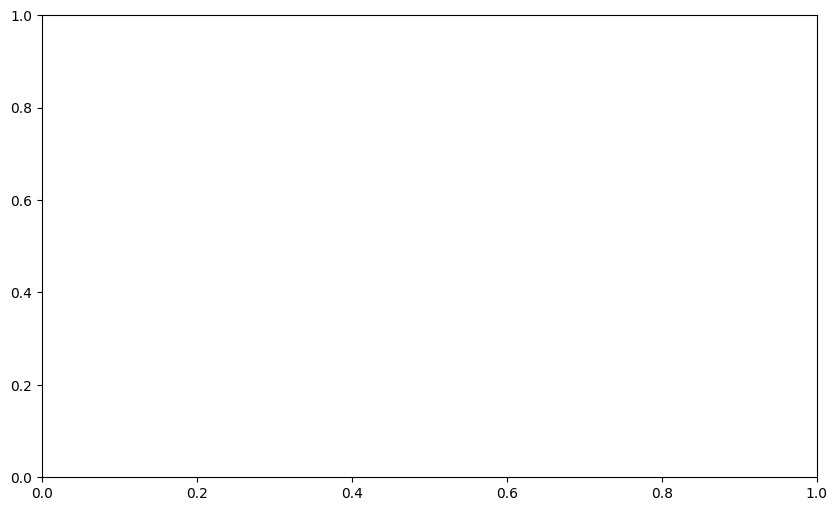

In [36]:
T_draw = np.linspace(0, 2, 100)
X_draw = np.zeros((100, 13))
X_draw[:, 0] = 1000
X_draw[:, 2] = 1
X_draw[:, 6] = 1

pred = mdl.ate(X=X_val, T0=0, T1=0.3)
lb, ub = mdl.effect_interval(
    X_val, alpha=0.01
)  # Get the prediction upper bound lower bound

# pre_ate = est2.ate(X=X_val, T0=0, T1=T_draw)
# effect_draw = est2.effect(X=X_draw, T0=0, T1=T_draw)
# marginal_effect_draw = est2.marginal_effect(T=T_draw, X=X_draw)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(T_val, pred, label="Effect of Treatment")
plt.xlabel("T_test")
plt.ylabel("Output")
plt.title("Effect of Treatment over T_test")
plt.legend()
plt.grid(True)
plt.show()

In [56]:
est = CausalForestDML(
    model_y=model_y,
    model_t=model_t,
    cv=3,
    n_estimators=4000,
    random_state=123,
)
est.ate()
# Fit the final model
est.tune(Y_train, T_train.reshape(-1, 1), X=X_train).fit(
    Y_train, T_train, X=X_train, cache_values=True
)

est1 = LinearDML(model_y=model_y, model_t=model_t, treatment_featurizer=featurizer)
effect
#     model_t=model_t,
#     cv=3,
#     mc_iters=3,
#     mc_agg="median",
# )
# scorer.fit(y=Y_train, T=T_train.reshape(-1, 1), X=X_train)

# scorer.score(est1)  # Get the R squer scroe

# pred = est1.effect(X=X_val)
# lb, ub = est.effect_interval(
#     X_val, alpha=0.01
# )  # Get the prediction upper bound lower bound

plt.figure(figsize=(10, 6))
test_T = np.arange(0, 2, step=0.1).reshape(-1, 1)

# Plot point estimates
plt.plot(
    test_T,
    est1.effect(T0=0, T1=test_T),
    label="Estimate with Featurized Treatment",
    linewidth=3,
)


from econml.dml import DML, LinearDML, SparseLinearDML, NonParamDML

est2 = DML(
    model_y=model_y,
    model_t=RandomForestRegressor(),
    model_final=LassoCV(fit_intercept=False),
    featurizer=PolynomialFeatures(degree=3, interaction_only=False, include_bias=False),
    cv=3,
)

est2.fit(Y=Y_train, T=T_train, X=X_train)

from econml.score import RScorer

scorer = RScorer(
    model_y=model_y,
    model_t=model_t,
    cv=3,
    mc_iters=3,
    mc_agg="median",
)
scorer.fit(Y_val, T_val, X=X_val)

scorer.score(est2)  # Get the R squer scroe


T_draw = np.linspace(0, 2, 5880)
X_draw = np.zeros((100, 13))
X_draw[:, 0] = 1000
X_draw[:, 2] = 1
X_draw[:, 6] = 1
pred = est2.effect(X=X_val, T0=0, T1=T_draw)
lb, ub = est.effect_interval(
    X_val, alpha=0.01
)  # Get the prediction upper bound lower bound

# pre_ate = est2.ate(X=X_val, T0=0, T1=T_draw)
# effect_draw = est2.effect(X=X_draw, T0=0, T1=T_draw)
# marginal_effect_draw = est2.marginal_effect(T=T_draw, X=X_draw)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(T_draw, pred, label="Effect of Treatment")
plt.xlabel("T_test")
plt.ylabel("Output")
plt.title("Effect of Treatment over T_test")
plt.legend()
plt.grid(True)
plt.show()

effect_draw = est2.ate(X=X_val, T0=0, T1=0.5)
T_draw = np.linspace(0, 2, 100)
X_draw = np.zeros((100, 13))
X_draw[:, 0] = 500
X_draw[:, 2] = 1
X_draw[:, 6] = 1

effect_draw = est.effect(X=X_draw, T0=0, T1=T_draw)
marginal_effect_draw = est.marginal_effect(T=T_draw, X=X_draw)


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(T_draw, marginal_effect_draw, label="Effect of Treatment")
plt.xlabel("T_test")
plt.ylabel("Output")
plt.title("Effect of Treatment over T_test")
plt.legend()
plt.grid(True)
plt.show()


import shap

shap_values = est2.shap_values(
    X_train,
    feature_names=[
        "initial_prompt_length",
    ]
    + model_columns
    + dataset_columns,
)

shap.plots.beeswarm(shap_values["Y0"]["T0"], max_display=100)

Co-variance matrix is underdetermined. Inference will be invalid!


AssertionError: X was not None when fitting, so can't be none for score or effect

<Figure size 1000x600 with 0 Axes>

In [2]:
# Define some parameters
n_trees = 1000
min_leaf_size = 50
max_depth = 20
subsample_ratio = 0.04

In [57]:
# # Main imports
# from econml.sklearn_extensions.linear_model import (
#     WeightedLassoCVWrapper,
#     WeightedLasso,
#     WeightedLassoCV,
# )
# from econml.orf import DMLOrthoForest, DROrthoForest

# est3 = DMLOrthoForest(
#     n_trees=n_trees,
#     min_leaf_size=min_leaf_size,
#     max_depth=max_depth,
#     subsample_ratio=subsample_ratio,
#     model_T=Lasso(alpha=0.1),
#     model_Y=Lasso(alpha=0.1),
#     model_T_final=WeightedLassoCVWrapper(cv=3),
#     model_Y_final=WeightedLassoCVWrapper(cv=3),
# )

# est3.fit(Y=Y_train, T=T_train, X=X_train)

# # Calculate treatment effects for the default treatment points T0=0 and T1=1
# treatment_effects = est3.effect(T0=0, T1=T_draw)
# te_lower, te_upper = est3.effect_interval(T0=0, T1=T_draw)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
networkx backend defined more than once: nx-loopback
networkx backend defined more than once: nx-loopback
networkx backend defined more than once: nx-loopback
networkx backend defined more than once: nx-loopback
networkx backend defined more than once: nx-loopback
networkx backend defined more than once: nx-loopback
networkx backend defined more than once: nx-loopback
networkx backend defined more than once: nx-loopback
networkx backend defined more than once: nx-loopback
networkx backend defined more than once: nx-loopback
networkx backend defined more than once: nx-loopback
networkx backend defined more than once: nx-loopback
networkx backend defined more than once: nx-loopback
networkx backend defined more than once: nx-loopback
networkx backend defined more than once: nx-loopback
networkx backend defined more than once: nx-loopback
networkx backend defined more than once: nx-loopback
networkx backend defin

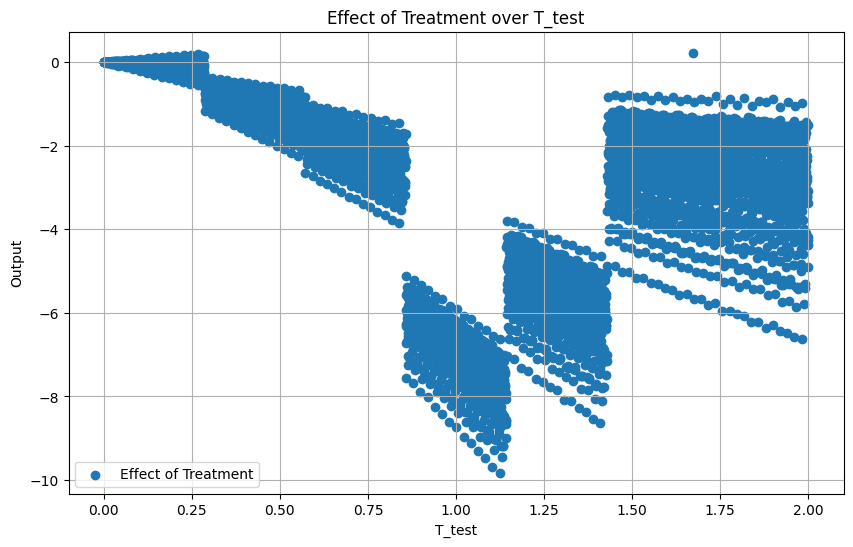

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(T_draw, treatment_effects, label="Effect of Treatment")
plt.xlabel("T_test")
plt.ylabel("Output")
plt.title("Effect of Treatment over T_test")
plt.legend()
plt.grid(True)
plt.show()